In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/tscc/nfs/home/hsher/Metadensity/config/hg38-tscc2.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
plt.style.use('seaborn-white')
from itertools import chain
from pathlib import Path
import deepdish as dd
import os
import glob

please set the right config according to genome coordinate
Using /home/hsher/gencode_coords/GRCh38.p13.genome.fa
Using HG38 by default
Using /tscc/nfs/home/hsher/gencode_coords/GRCh38.p13.genome.fa


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-63has1ke because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Using:  /tscc/nfs/home/hsher/gencode_coords/gencode.v33.transcript.gff3


This notebook looks at the relative mean intensity difference between canonical and non-canonical PAS sites after scaling each

In [2]:
base_dir = './'

In [3]:
#dd.io.load(os.path.join(base_dir, '{}_prox_passeqSite_200.h5'.format('GRB2')))

In [4]:
import numpy as np
import seaborn as sns
rna = ['prox','dist']
#protein_coding = ['five_prime_UTR', 'first_CDS', 'CDS', 'last_CDS', 'three_prime_UTR']
################## I KNOW THIS IS INELEGANT BUT WE STILL NEED TO SET COLORS #################
color_dict = {
              'prox start': 'hotpink',
              'prox end': 'deeppink','dist start': 'seagreen',
              'dist end': 'lightseagreen',

     }
key_to_name = {'prox': 'prox',
              'dist': 'dist'}

def read_precomputed_array(uid,loc, base_dir = base_dir):
    ''' load deep dish h5 into data structure'''
    return dd.io.load(os.path.join(base_dir, '{}_{}_sample200_length200.h5'.format(uid, loc)))
def get_feature_length(denarray):
    ''' return feature length for each feature in dictionary'''
    features = list(set([d[0] for d in denarray.keys()]))
    feature_len = [denarray[f, 'left', 'rep1'].shape[1] for f in features]
    return dict(zip(features, feature_len))
def merge_two_reps(denarray, features = rna):
    ''' merge two rep, return mean density'''
    all_mean = []
    for f in features:
        for align in ['left', 'right']:

            rep1 = denarray[f, align, 'rep1']
            rep2 = denarray[f, align, 'rep2']

            all_den = np.concatenate([rep1,rep2], axis = 0) # concat into 1 array
            mean = np.nanmean(all_den, axis = 0)
            all_mean.append(mean)
    return(np.concatenate(all_mean))
def into_one_df(uids, l, features = rna):
    ''' given a list of uid, concat all features and data into 1 df'''
    all_vector = []
    i = 0
    for uid in uids:
        denarray = read_precomputed_array(uid, l)
        if i == 0:
            flen = get_feature_length(denarray)
        all_vector.append(merge_two_reps(denarray, features)) # append into results
        i+=1



    df = pd.DataFrame(np.stack(all_vector), index = uids)
    df.fillna(0, inplace = True)
    df.replace(np.nan, 0, inplace = True)

    return df , flen

def get_feat_color(features, flen):
    ''' generate color annotation for heatmap'''
    # get feature length
    colors = []
    names = []
    for f in features:
        length = flen[f]
        name = key_to_name[f]

        for align in ['start', 'end']:
            color_key = '{} {}'.format(name, align)
            names.append(color_key)
            colors += [color_dict[color_key]]*length

    return colors, names


In [5]:
full_list = set([i.split('/')[1].split('_')[0] for i in glob.glob(os.path.join('./','*.h5'))])

In [6]:
#remove = ['RBM22', 'EIF4B', 'STAU2' ]

In [7]:
store_meta = {}
for c in full_list:
    store_meta[c] = {}
    for z in ['PROXIMAL', 'DISTAL']:
        df, flen = into_one_df([c],z, rna)
        rna_color, names = get_feat_color(rna, flen)
        store_meta[c][z]=df
        # if strand_dict[c] == "+":  
        #     store_meta[c][z]=df
        # else:
        #     print(c,z)
        #     store_meta[c][z]=pd.DataFrame(df.T[c].tolist()[::-1]).rename(columns={0:c}).T
#     sns.lineplot(x=store_meta[c]['PROXIMAL'].T.index, y=store_meta[c]['PROXIMAL'].T[c], color='purple')
    
#     sns.lineplot(x=store_meta[c]['DISTAL'].T.index, y=store_meta[c]['DISTAL'].T[c], color='lightseagreen')
#     #sns.lineplot(x=store_meta[c]['no'].T.index, y=store_meta[c]['no'].T[c])
#     plt.title(c)
#     plt.axvline(x=200, linestyle='dashed', color='grey')
#     plt.axvline(x=400, color='black')
#     plt.axvline(x=600, linestyle='dashed', color='grey')
#     plt.legend(['PROXIMAL', 'DISTAL'])
#     plt.ylim(0)
#     plt.show()


/opt/conda/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


In [8]:
feature_info = pd.read_csv('./prox_dist_metadensity_features.txt', sep='\t', header=None)

In [9]:
feature_dict = feature_info.groupby(0).apply(lambda r: dict(zip(r[1], r[2]))).to_dict()


In [10]:
feature_dict

{'CPSF6': {'DISTAL': 36, 'PROXIMAL': 122},
 'EIF4B': {'DISTAL': 4, 'PROXIMAL': 21},
 'GRB2': {'DISTAL': 51, 'PROXIMAL': 23},
 'MBNL2': {'DISTAL': 308, 'PROXIMAL': 71},
 'NUDT21': {'DISTAL': 100, 'PROXIMAL': 650},
 'RBM22': {'DISTAL': 3, 'PROXIMAL': 1},
 'RBM5': {'DISTAL': 3, 'PROXIMAL': 130},
 'RNPS1': {'DISTAL': 10, 'PROXIMAL': 9},
 'STAU2': {'DISTAL': 3, 'PROXIMAL': 4},
 'TRNAU1AP': {'DISTAL': 51, 'PROXIMAL': 23},
 'ZC3HAV1': {'DISTAL': 138, 'PROXIMAL': 66},
 'ZMAT3': {'DISTAL': 8, 'PROXIMAL': 23}}

In [11]:
import numpy as np

In [12]:
def scale_array(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

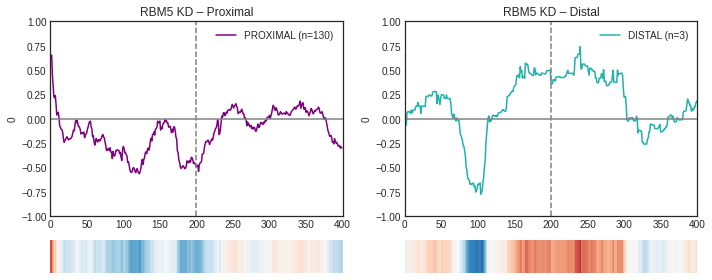

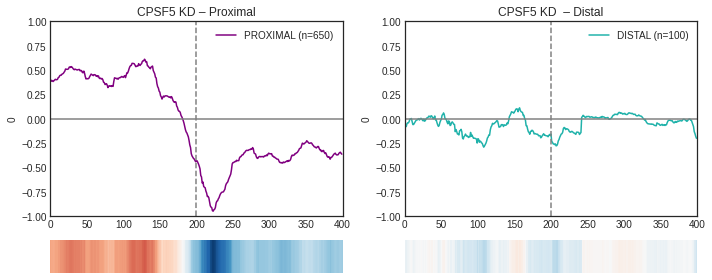

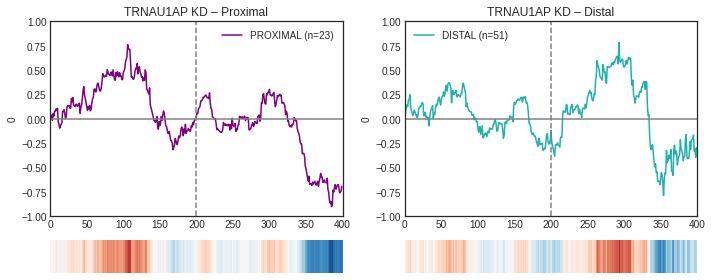

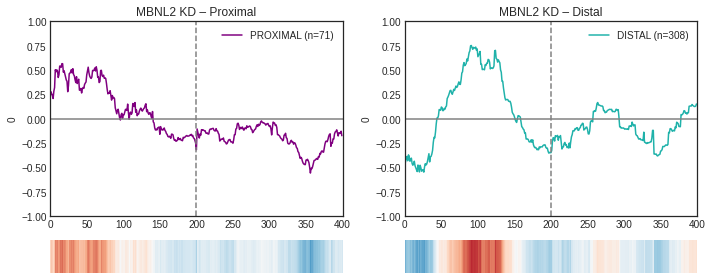

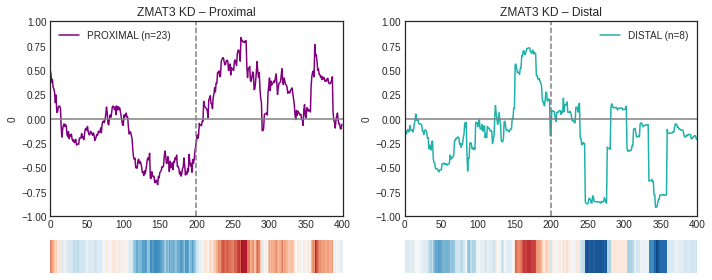

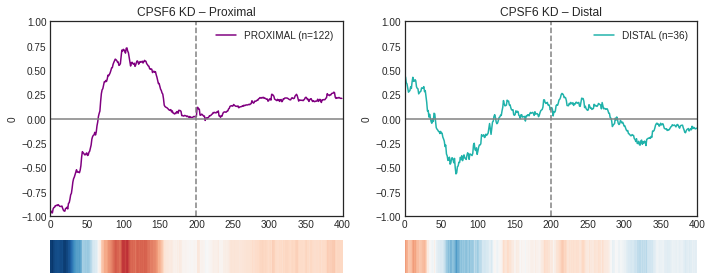

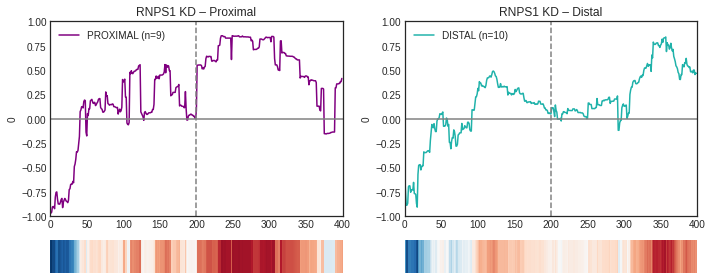

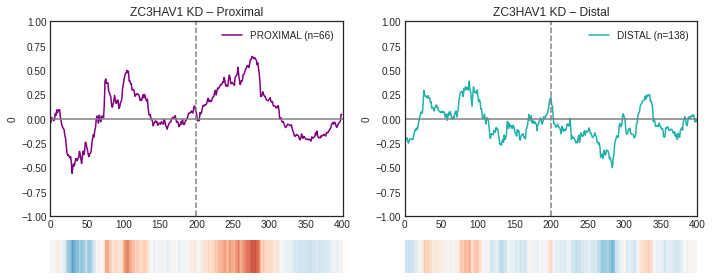

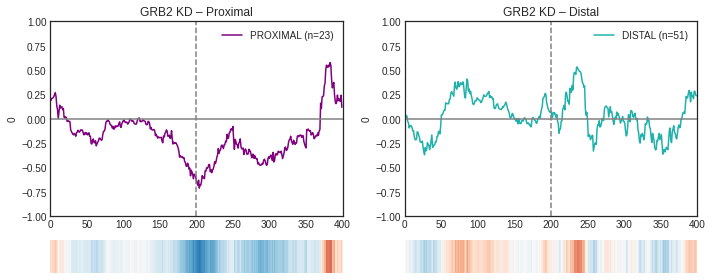

In [13]:
store_meta = {}
for c in full_list:
    if c not in remove:
        store_meta[c] = {}
        for z in ['PROXIMAL', 'DISTAL']:
            df, flen = into_one_df([c],z, rna)
            rna_color, names = get_feat_color(rna, flen)

            if z=='PROXIMAL':
                canonical = scale_array(np.array(df.iloc[:,400:]))
                kd = scale_array(np.array(df.iloc[:,0:400]))
                
            else:
                canonical = scale_array(np.array(df.iloc[:,0:400]))
                kd = scale_array(np.array(df.iloc[:,400:]))
        
            store_meta[c][z]=pd.DataFrame(canonical - kd) 
                
        fig = plt.figure(figsize=(10, 4))

        # Define GridSpec with height ratios
        gs = gridspec.GridSpec(2, 2, height_ratios=[1.5, 0.25], figure=fig)

        # Create subplots using GridSpec indexing
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[1, 1])


        if c != 'CPSF5':
            # Prox plot
            sns.lineplot(
                x=store_meta[c]['PROXIMAL'].T.index,
                y=store_meta[c]['PROXIMAL'].T[0],
                color='purple',
                ax=ax1
            )
            ax1.set_title(f'{c} KD – Proximal')
            ax1.axvline(x=200, linestyle='dashed', color='grey')
            ax1.axhline(y=0, linestyle='solid', color='grey')
            ax1.set_ylim(bottom=-1, top=1)
            ax1.set_xlim(0,400)
            ax1.legend([f'PROXIMAL (n={feature_dict[c]["PROXIMAL"]})'])
            sns.heatmap(store_meta[c]['PROXIMAL'], ax=ax3, cbar=False,vmax=1, vmin=-1,cmap='RdBu_r')
            ax3.set_xticks([])
            ax3.set_yticks([])

            # Dist plot
            sns.lineplot(
                x=store_meta[c]['DISTAL'].T.index,
                y=store_meta[c]['DISTAL'].T[0],
                color='lightseagreen',
                ax=ax2
            )
            ax2.set_title(f'{c} KD – Distal')
            ax2.axvline(x=200, linestyle='dashed', color='grey')
            ax2.set_ylim(bottom=-1, top=1)
            ax2.axhline(y=0, linestyle='solid', color='grey')
            ax2.set_xlim(0,400)
            ax2.legend([f'DISTAL (n={feature_dict[c]["DISTAL"]})'])
            
            sns.heatmap(store_meta[c]['DISTAL'], ax=ax4, cbar=False, vmax=1, vmin=-1,cmap='RdBu_r')
            ax4.set_xticks([])
            ax4.set_yticks([])
            plt.tight_layout()
            plt.show()
            

        else:
            # Prox plot
            sns.lineplot(
                x=store_meta[c]['PROXIMAL'].T.index,
                y=store_meta[c]['PROXIMAL'].T[0],
                color='purple',
                ax=ax1
            )
            ax1.set_title(f'{c} KD – Proximal')
            ax1.axvline(x=200, linestyle='dashed', color='grey')
            ax1.axhline(y=0, linestyle='solid', color='grey')
            ax1.set_ylim(bottom=-1, top=1)
            ax1.set_xlim(0,400)
            ax1.legend([f'PROXIMAL (n={feature_dict["NUDT21"]["PROXIMAL"]})'])
            sns.heatmap(store_meta[c]['PROXIMAL'], ax=ax3, cbar=False,vmax=1, vmin=-1,cmap='RdBu_r')
            ax3.set_xticks([])
            ax3.set_yticks([])

            # Dist plot
            sns.lineplot(
                x=store_meta[c]['DISTAL'].T.index,
                y=store_meta[c]['DISTAL'].T[0],
                color='lightseagreen',
                ax=ax2
            )
            ax2.set_title(f'{c} KD  – Distal')
            ax2.axvline(x=200, linestyle='dashed', color='grey')
            ax2.set_ylim(bottom=-1, top=1)
            ax2.axhline(y=0, linestyle='solid', color='grey')
            ax2.set_xlim(0,400)
            ax2.legend([f'DISTAL (n={feature_dict["NUDT21"]["DISTAL"]})'])
            
            sns.heatmap(store_meta[c]['DISTAL'], ax=ax4, cbar=False, vmax=1, vmin=-1,cmap='RdBu_r')
            ax4.set_xticks([])
            ax4.set_yticks([])
            plt.tight_layout()
            plt.show()



In [14]:
meta_prox_all = pd.DataFrame()
meta_dist_all = pd.DataFrame()
for c in store_meta:
    if c != 'CPSF5':
        if feature_dict[c]['PROXIMAL'] >= 10:
            meta_prox_all = pd.concat([meta_prox_all,  store_meta[c]['PROXIMAL'].assign(index_label=c)])
        if feature_dict[c]['DISTAL'] >= 10:
            meta_dist_all = pd.concat([meta_dist_all,  store_meta[c]['DISTAL'].assign(index_label=c)])
    else:
        if feature_dict['NUDT21']['PROXIMAL'] >= 10:
            meta_prox_all = pd.concat([meta_prox_all,  store_meta['CPSF5']['PROXIMAL'].assign(index_label='CPSF5')])
        if feature_dict['NUDT21']['DISTAL'] >= 10:
            meta_dist_all = pd.concat([meta_dist_all,  store_meta['CPSF5']['DISTAL'].assign(index_label='CPSF5')])
meta_prox_all = meta_prox_all.set_index('index_label')
meta_dist_all = meta_dist_all.set_index('index_label')

In [15]:
meta_prox_all.sort_index()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
index_label,,,,,,,,,,,,,,,,,,,,,
CPSF5,0.399524,0.385335,0.394771,0.387066,0.382419,0.389975,0.399020,0.405164,0.401691,0.400839,...,-0.353697,-0.366625,-0.372038,-0.371567,-0.369479,-0.355568,-0.347898,-0.344080,-0.355355,-0.364238
CPSF6,-0.946172,-0.947059,-0.966000,-0.967534,-0.926028,-0.912665,-0.909506,-0.893205,-0.893296,-0.887934,...,0.220691,0.208720,0.217623,0.212891,0.212985,0.218732,0.213641,0.209115,0.210158,0.208386
GRB2,0.196874,0.187112,0.206752,0.212468,0.215346,0.227662,0.250104,0.267250,0.226283,0.132149,...,0.177808,0.154678,0.177798,0.242747,0.184398,0.206677,0.184916,0.179147,0.241751,0.117577
MBNL2,0.211950,0.277043,0.255342,0.243720,0.207587,0.282927,0.320083,0.503328,0.482412,0.502437,...,-0.135638,-0.130832,-0.114043,-0.144127,-0.177099,-0.143836,-0.146770,-0.148064,-0.128401,-0.174535
RBM5,0.635009,0.647756,0.653762,0.450761,0.331263,0.229224,0.214832,0.238613,0.148472,0.037561,...,-0.228609,-0.249559,-0.243456,-0.260532,-0.281233,-0.274507,-0.277023,-0.301272,-0.289510,-0.300514
TRNAU1AP,-0.007895,0.004304,0.036811,-0.016157,0.051023,0.026652,0.076061,0.077290,0.099060,0.088806,...,-0.675648,-0.722861,-0.698214,-0.683075,-0.675667,-0.707590,-0.761049,-0.753738,-0.741669,-0.694564
ZC3HAV1,-0.053296,-0.034064,0.012833,-0.003795,-0.011461,-0.020014,-0.008097,0.054051,0.035982,0.091998,...,-0.043545,-0.072221,-0.088972,-0.076297,-0.053066,-0.044604,-0.034819,-0.021701,0.044270,0.045874
ZMAT3,0.501073,0.457164,0.373295,0.404591,0.321016,0.307520,0.269956,0.165650,0.243586,0.065210,...,-0.095768,-0.011838,0.029056,0.058444,-0.014229,-0.054450,-0.054252,-0.102415,-0.104924,-0.057596


In [16]:
meta_prox_all[meta_prox_all.index!='CPSF5']

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
index_label,,,,,,,,,,,,,,,,,,,,,
RBM5,0.635009,0.647756,0.653762,0.450761,0.331263,0.229224,0.214832,0.238613,0.148472,0.037561,...,-0.228609,-0.249559,-0.243456,-0.260532,-0.281233,-0.274507,-0.277023,-0.301272,-0.289510,-0.300514
TRNAU1AP,-0.007895,0.004304,0.036811,-0.016157,0.051023,0.026652,0.076061,0.077290,0.099060,0.088806,...,-0.675648,-0.722861,-0.698214,-0.683075,-0.675667,-0.707590,-0.761049,-0.753738,-0.741669,-0.694564
MBNL2,0.211950,0.277043,0.255342,0.243720,0.207587,0.282927,0.320083,0.503328,0.482412,0.502437,...,-0.135638,-0.130832,-0.114043,-0.144127,-0.177099,-0.143836,-0.146770,-0.148064,-0.128401,-0.174535
ZMAT3,0.501073,0.457164,0.373295,0.404591,0.321016,0.307520,0.269956,0.165650,0.243586,0.065210,...,-0.095768,-0.011838,0.029056,0.058444,-0.014229,-0.054450,-0.054252,-0.102415,-0.104924,-0.057596
CPSF6,-0.946172,-0.947059,-0.966000,-0.967534,-0.926028,-0.912665,-0.909506,-0.893205,-0.893296,-0.887934,...,0.220691,0.208720,0.217623,0.212891,0.212985,0.218732,0.213641,0.209115,0.210158,0.208386
ZC3HAV1,-0.053296,-0.034064,0.012833,-0.003795,-0.011461,-0.020014,-0.008097,0.054051,0.035982,0.091998,...,-0.043545,-0.072221,-0.088972,-0.076297,-0.053066,-0.044604,-0.034819,-0.021701,0.044270,0.045874
GRB2,0.196874,0.187112,0.206752,0.212468,0.215346,0.227662,0.250104,0.267250,0.226283,0.132149,...,0.177808,0.154678,0.177798,0.242747,0.184398,0.206677,0.184916,0.179147,0.241751,0.117577


In [ ]:
screen_results = {'CPSF5':,'Upstream',
 'CPSF6':'Upstream',
 'TRNAU1AP': 'Both',
 'GRB2': 'Both',
 'MBNL2': 'Both',
 'ZC3HAV1': 'Both',
 'RBM5': 'Both',
 'ZMAT3': 'Downstream',
 'RBM22':  'Downstream',
 'EIF4B' : 'Both', 
 'STAU2': 'Downstream'}

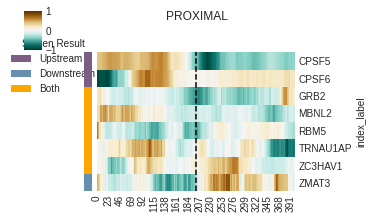

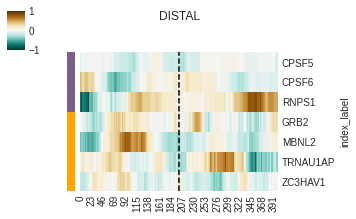

In [41]:
import seaborn as sns
import pandas as pd

# Your annotation dictionary
screen_results = {
    'CPSF5': 'Upstream',
    'CPSF6': 'Upstream',
    'TRNAU1AP': 'Both',
    'GRB2': 'Both',
    'MBNL2': 'Both',
    'ZC3HAV1': 'Both',
    'RBM5': 'Both',
    'ZMAT3': 'Downstream',
    'RBM22': 'Downstream',
    'EIF4B': 'Both',
    'STAU2': 'Downstream',
    'RNPS1': 'Upstream'
}

# Make into a Series aligned with your dataframe index
annotation = pd.Series(screen_results)

# Choose a colorblind-friendly palette for categories
palette = {
    'Upstream': '#7C5D86',   # purple
    'Downstream': '#668EB1', # blue
    'Both': '#FFA500'        # green
}

row_colors = annotation.map(palette)

# Now pass row_colors into clustermap
g1 = sns.clustermap(
    meta_prox_all.sort_index(),
    cmap='BrBG_r',
    row_cluster=False, col_cluster=False,
    figsize=(5, 3),
    vmax=1, vmin=-1,
    row_colors=row_colors  # <- annotation
)
g1.ax_heatmap.axvline(x=200, color='black', linestyle='--')
g1.fig.suptitle('PROXIMAL')

order = ['CPSF5', 'CPSF6', 'RNPS1'] + [g for g in meta_dist_all.sort_index().index if g not in ['CPSF5','CPSF6','RNPS1']]

g2 = sns.clustermap(
    meta_dist_all.loc[order],
    cmap='BrBG_r',
    row_cluster=False,  # <- disables reordering
    col_cluster=False,
    figsize=(5,3),
    vmin=-1, vmax=1,
    row_colors=row_colors
)

g2.ax_heatmap.axvline(x=200, color='black', linestyle='--')
g2.fig.suptitle('DISTAL')

# Add a legend manually (for categories)
for label in palette:
    g1.ax_row_dendrogram.bar(0, 0, color=palette[label], label=label, linewidth=0)
g1.ax_row_dendrogram.legend(
    title="Screen Result", loc="center", ncol=1, bbox_to_anchor=(0.5, 0.9)
)
g1.savefig('heatmap_proximal_scaled_difference.png')
g1.savefig('heatmap_proximal_scaled_difference.svg')
g1.savefig('heatmap_proximal_scaled_difference.jpg')
g2.savefig('heatmap_distal_scaled_difference.png')
g2.savefig('heatmap_distal_scaled_difference.svg')
g2.savefig('heatmap_distal_scaled_difference.jpg')